In [58]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

In [15]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Load images

Select folders of the same person

In [16]:
def list_files_in_folder(filepath):
    filepath = tf.strings.join([filepath, f'{os.path.sep}*.jpg'])
    
    return tf.data.Dataset.list_files(filepath, shuffle=True)

In [32]:
def get_label(filepath):
    return tf.strings.split(filepath, os.path.sep)[2]

In [48]:
def process_image(filepath):
    label = get_label(filepath)
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [128, 128])
    return img / 255.0, label

In [49]:
def create_batch(dataset, batch_size=1800, faces_per_identity=40):
    identities = batch_size // faces_per_identity
    
    identity_dataset = dataset.take(identities)
    
    first = True
    
    for identity in identity_dataset:
        if first:
            faces = identity.take(faces_per_identity)
            first = False
        else:
            faces = faces.concatenate(identity.take(faces_per_identity))
        
    faces = faces.map(process_image)
    return faces

In [60]:
batch_size = 128

dataset = tf.data.Dataset.list_files('data/train/*', shuffle=True)
dataset = dataset.map(list_files_in_folder)

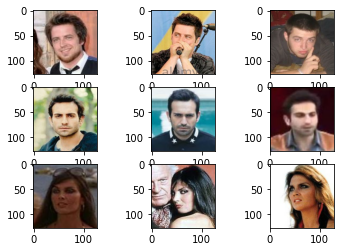

In [92]:
faces = create_batch(dataset, batch_size=9, faces_per_identity=3)

fig, axs = plt.subplots(3, 3)
i = 0

for image, label in faces:
    x = i // 3
    y = i % 3
    i += 1
    
    axs[x, y].imshow(image)

In [ ]:
faces = create_batch(dataset, batch_size=9, faces_per_identity=3)